# Inversion on Unimak Island

This is the noteboook that solves the inversion for the Unimak datasets

## Load libraries

In [1]:
%matplotlib notebook
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util

# Load the downsampled InSAR image

In this step we load the downsampled descending InSAR velocity field and the mask for nan values

In [2]:
mask=np.load('examples/insar/mask_unimak_des.npy')
csvfile='examples/insar/unimak_des_ref.csv'
qmap,extent,rcoords=util.get_defmap(csvfile,mask=mask,trans=False)

# InSAR (descending) data object

Here we load the csv file into an Insar object

In [3]:
from vmod.data import Insar
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher.txt')
#xs,ys,azs,lks,los,elos,ref=util.read_dataset_csv('fisher_ref.txt')
#obs=Insar()
#obs.add_vecs(azs,lks)
#obs.add_xs(xs)
#obs.add_ys(ys)
#obs.add_los(los)
#obs.add_ref(ref)
#obs=util.csv2insar('fisher.txt')
csvfile_ref='examples/insar/unimak_des_ref.csv'
obsin_des=Insar()
obsin_des.importcsv(csvfile,ori=[-164.5,54.7])
#obsin.err=obsin.err*0.0+1.0

# Load GNSS dataset

In this step we load the text file containing the GNSS velocities

In [4]:
csvfile='examples/gps/unimak_gnss_NOAM.txt'
names,lons,lats,uxs,uys,uzs,euxs,euys,euzs=util.read_gnss_csv(csvfile,trans=False)

<IPython.core.display.Javascript object>


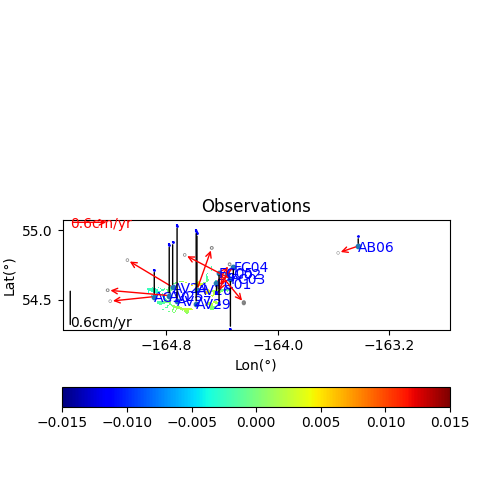

In [5]:
util.plot_gnss(lons,lats,uxs,uys,uzs,'Observations',names,euxs,euys,euzs,scl=0.6,unit='deg')

In [6]:
plt.imshow(qmap,extent=extent,vmin=-0.015,vmax=0.015,cmap='jet')
plt.colorbar(orientation='horizontal')

# InSAR (ascending) data object

Here we load the downsampled InSAR dataset into an Insar object

In [7]:
from vmod.data import Insar

#Creating observation object in this case an 
#InSAR dataset 
obsin_asc=Insar()

#Add azimuth and incidence angles
#obsin_asc.add_vecs(azs,lks)

#Add x and y coordinates
#obsin_asc.add_xs(xs)
#obsin_asc.add_ys(ys)

#Add LOS deformation data
#obsin_asc.add_los(los)

#Add reference point in (x,y) coordinates
#obsin_asc.add_ref(ref)

#Import csv into observation object
csvfile_ref='examples/insar/unimak_asc_ref.csv'
obsin_asc.importcsv(csvfile_ref,ori=[-164.5,54.7])

In [8]:
mask=np.load('examples/insar/mask_unimak_asc.npy')
csvfile='examples/insar/unimak_asc_ref.csv'
qmap,extent,rcoords=util.get_defmap(csvfile,mask=mask,trans=False)

# Plot GNSS dataset with ascending InSAR dataset

In [9]:
csvfile='examples/gps/unimak_gnss_NOAM.txt'
names,lons,lats,uxs,uys,uzs,euxs,euys,euzs=util.read_gnss_csv(csvfile,trans=False)

<IPython.core.display.Javascript object>


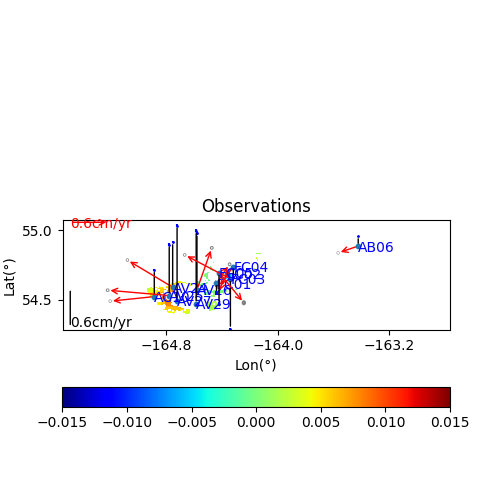

In [10]:
util.plot_gnss(lons,lats,uxs,uys,uzs,'Observations',names,euxs,euys,euzs,scl=0.6,unit='deg')

In [11]:
plt.imshow(qmap,extent=extent,vmin=-0.015,vmax=0.015,cmap='jet')
plt.colorbar(orientation='horizontal')

# Import GNSS dataset into a Gnss object

Here we import the csv file with the GNSS velocities and put it into a Gnss object

In [12]:
from vmod.data import Gnss

#Creating observation object in this case 
#an GNSS dataset 
obsg=Gnss()

#Add the names of the stations
#obsg.add_names(names)

#Add the x and y coordinates 
#of the stations
#obsg.add_xs(xs)
#obsg.add_ys(ys)

#Add deformation dataset in east (uxs), 
#north (uys) and vertical (uzs)
#obsg.add_ux(uxs)
#obsg.add_uy(uys)
#obsg.add_uz(uzs)

#Add uncertainties in east (euxs), 
#north (euys) and vertical (euzs)
#obsg.add_errx(euxs)
#obsg.add_erry(euys)
#obsg.add_errz(euzs)

#Import csv into the observation object
obsg.importcsv(csvfile,ori=[-164.5,54.7])
obsg.add_ref('AB06')

# Defining Joint dataset object

In this step, we create a Joint object with the InSAR dataset (ascending and descending) and the GNSS dataset

In [13]:
from vmod.data import Joint

#Creating observation object in 
#this case a Joint dataset
obs=Joint()

#Adding each dataset object, the 
#user has to provide the relative
#weight of each dataset
#obs.add_dataset(obsin_des,wt=wt_insar)
#obs.add_dataset(obsin_asc,wt=wt_insar)
#obs.add_dataset(obsg,wt=wt_gps)



obs.add_dataset(obsin_des,wt=1.0)
obs.add_dataset(obsin_asc,wt=1.0)
obs.add_dataset(obsg,wt=(len(obsin_des.xs)+len(obsin_asc.xs))/(750*len(obsg.xs)))

# Model and Inverse objects

Here we create the model and inverse objects to run the inversions. We created some auxiliary objects for plotting purposes.

In [14]:
from vmod.source import Mctigue
from vmod.source import Penny
from vmod.source import Okada
from vmod.source import Yang
from vmod.inverse import Inverse

################# Model objects just for plotting##########################################
ygg = Yang(obsg)
ygg.set_x0([10e3,10e3,5e3,-1e5,5e3,1e3,1,1])
#Bounds for parameters
ygg.set_bounds(low_bounds = [0,0,1e3,-1e6,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,-1e4,7e3,7e3,359,89])

mctg = Mctigue(obsg)
mctg.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mctg.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,1e5], high_bounds = [0,0,15e3,5e3,1e7])

invg=Inverse(obsg)
invg.register_source(ygg)
invg.register_source(mctg)

ygin_des = Yang(obsin_des)
ygin_des.set_x0([10e3,10e3,5e3,-1e5,5e3,1e3,1,1])
#Bounds for parameters
ygin_des.set_bounds(low_bounds = [0,0,1e3,-1e6,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,-1e4,7e3,7e3,359,89])

mctin_des = Mctigue(obsin_des)
mctin_des.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mctin_des.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,1e5], high_bounds = [0,0,15e3,5e3,1e7])

invin_des=Inverse(obsin_des)
invin_des.register_source(ygin_des)
invin_des.register_source(mctin_des)

ygin_asc = Yang(obsin_asc)
ygin_asc.set_x0([10e3,10e3,5e3,-1e5,5e3,1e3,1,1])
#Bounds for parameters
ygin_asc.set_bounds(low_bounds = [-10000,-10000,1e3,-1e6,1e3,1e3,0.1,0.1], high_bounds = [20000,20000,15e3,-1e4,7e3,7e3,359,89])

mctin_asc = Mctigue(obsin_asc)
mctin_asc.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mctin_asc.set_bounds(low_bounds = [-20000,-20000,1e3,1e2,1e5], high_bounds = [0,0,15e3,5e3,1e7])

invin_asc=Inverse(obsin_asc)
invin_asc.register_source(ygin_asc)
invin_asc.register_source(mctin_asc)

################# Model objects just for plotting##########################################

################# Model objects for Joint dataset##########################################
yg = Yang(obs)
yg.set_x0([8e3,-4e3,6e3,-8e6,7e3,3e2,35,20])
#Bounds for parameters
yg.set_bounds(low_bounds = [-10000,-10000,1e3,-1e9,1e1,1e1,0.1,0.1], high_bounds = [20000,20000,15e3,1e9,30e3,30e3,359,89])

#Creating model object in this case a spherical source
mct = Mctigue(obs)
#Defining the starting point for an inversion 
#The parameters are location (x,y), depth, radius and volume change
mct.set_x0([-7e3,-7e3,5e3,1e3,3e6])
#Bounds for parameters
mct.set_bounds(low_bounds = [-30000,-30000,1e3,1e2,1e5], high_bounds = [0,0,15e3,10e3,1e7])

inv=Inverse(obs)
inv.register_source(yg)
inv.register_source(mct)
################# Model objects for Joint dataset##########################################

# Non-linear least squares inversion

In this step we run the non-linear least squares inversion and print the results

In [15]:
ans=inv.nlsq()

parnames,orders=inv.get_parnames_orders()
for i,parname in enumerate(parnames):
    print(parname,ans.x[i])

/home/jovyan/notebooks/ASF/vmod_git2/vmod/vmod/source/yang.py:127: RuntimeWarning: invalid value encountered in sqrt
  c = np.sqrt(a ** 2 - b ** 2)


0.002467478223331937
xcen0 7720.152027129174
ycen0 -2340.2856788438235
depth0 7096.959861047355
pressure0 -17104219.112806156
a0 935.1637464419861
b0 590.0998784320261
az0 81.92791296834159
dip0 18.726755191280258
xcen1 -10443.435780697793
ycen1 -19485.59145490721
depth1 7479.414605560552
radius1 597.9419552525683
dV1 4687996.37408698


## Plotting results from nlsq

Here we use the auxiliary objects to plot the results from the nlsq inversion

In [16]:
los_des=invin_des.forward(ans.x)
los_asc=invin_asc.forward(ans.x)

<IPython.core.display.Javascript object>


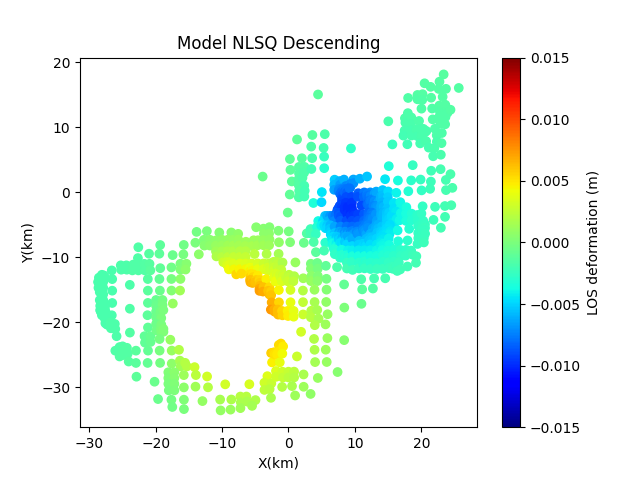

<IPython.core.display.Javascript object>


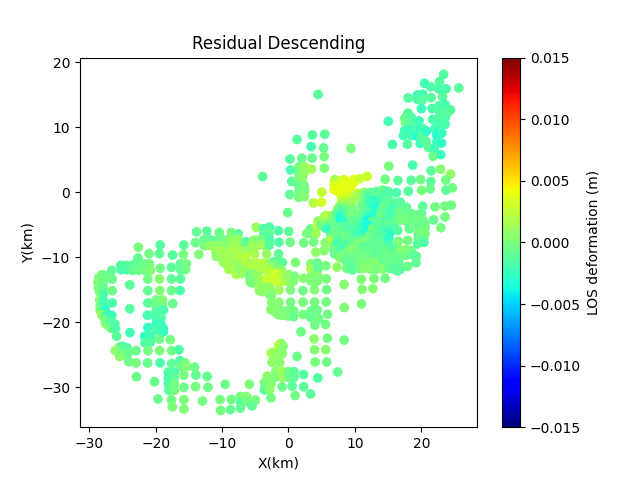

19.388347112494863 895


In [17]:
plt.figure()
plt.title('Model NLSQ Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=obsin_des.get_data()-los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_des.get_data()-los_des)*1e2)**2),len(los_des))

<IPython.core.display.Javascript object>


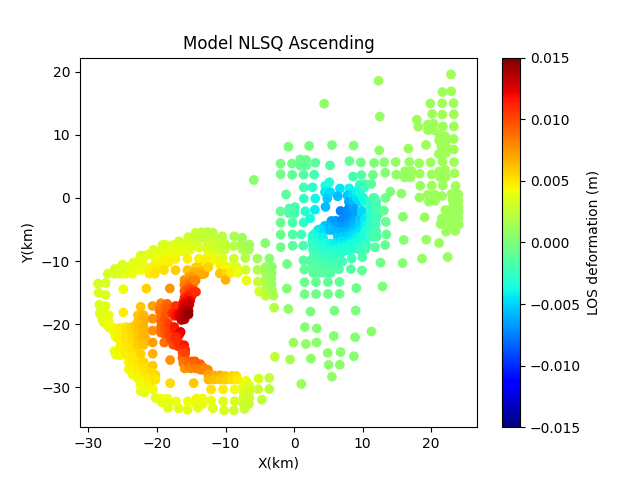

<IPython.core.display.Javascript object>


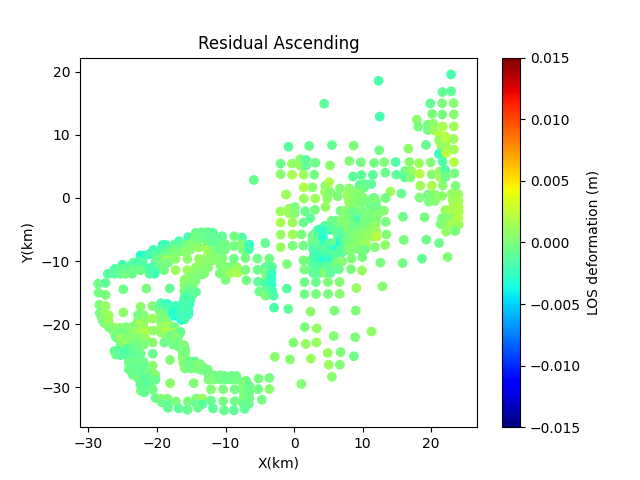

9.02772869902873 800


In [18]:
plt.figure()
plt.title('Model NLSQ Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=obsin_asc.get_data()-los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_asc.get_data()-los_asc)*1e2)**2),len(los_asc))

<IPython.core.display.Javascript object>


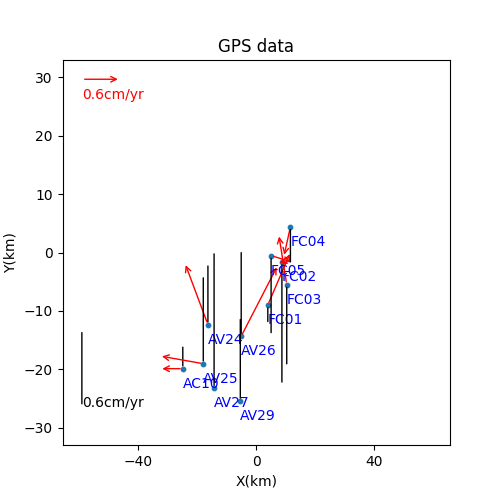

<IPython.core.display.Javascript object>


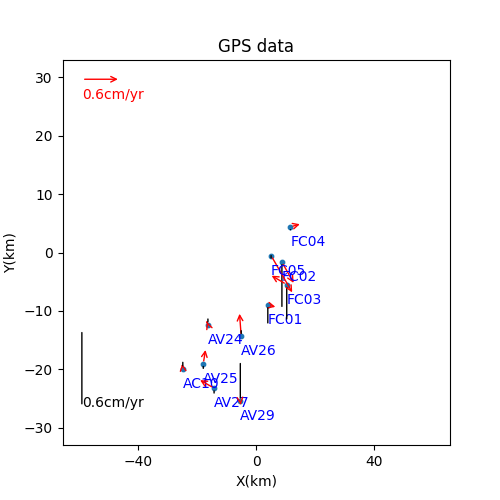

In [19]:
uxsm,uysm,uzsm=invg.forward(ans.x,unravel=False)

uxs,uys,uzs=obsg.get_data(unravel=False)

util.plot_gnss(obsg.xs,obsg.ys,uxsm,uysm,uzsm,names=names,scl=0.6)

util.plot_gnss(obsg.xs,obsg.ys,uxs-uxsm,uys-uysm,uzs-uzsm,names=names,scl=0.6)

# Bayesian inversion

When we run the next cell the Bayesian inversion will start

In [21]:
#trace,MDL=inv.mcmc('unimak_joint')

The traces from the Bayesian inversion are stored in a .pkl file

In [20]:
import pickle
with open('unimak_joint.pkl','rb') as handle:
    dic=pickle.load(handle)

trace=[dic[key] for key in dic.keys()]

## Plotting results from Bayesian inversion

Here we use the corner library to plot the posterior distributions and we use the auxiliary objects to plot the results

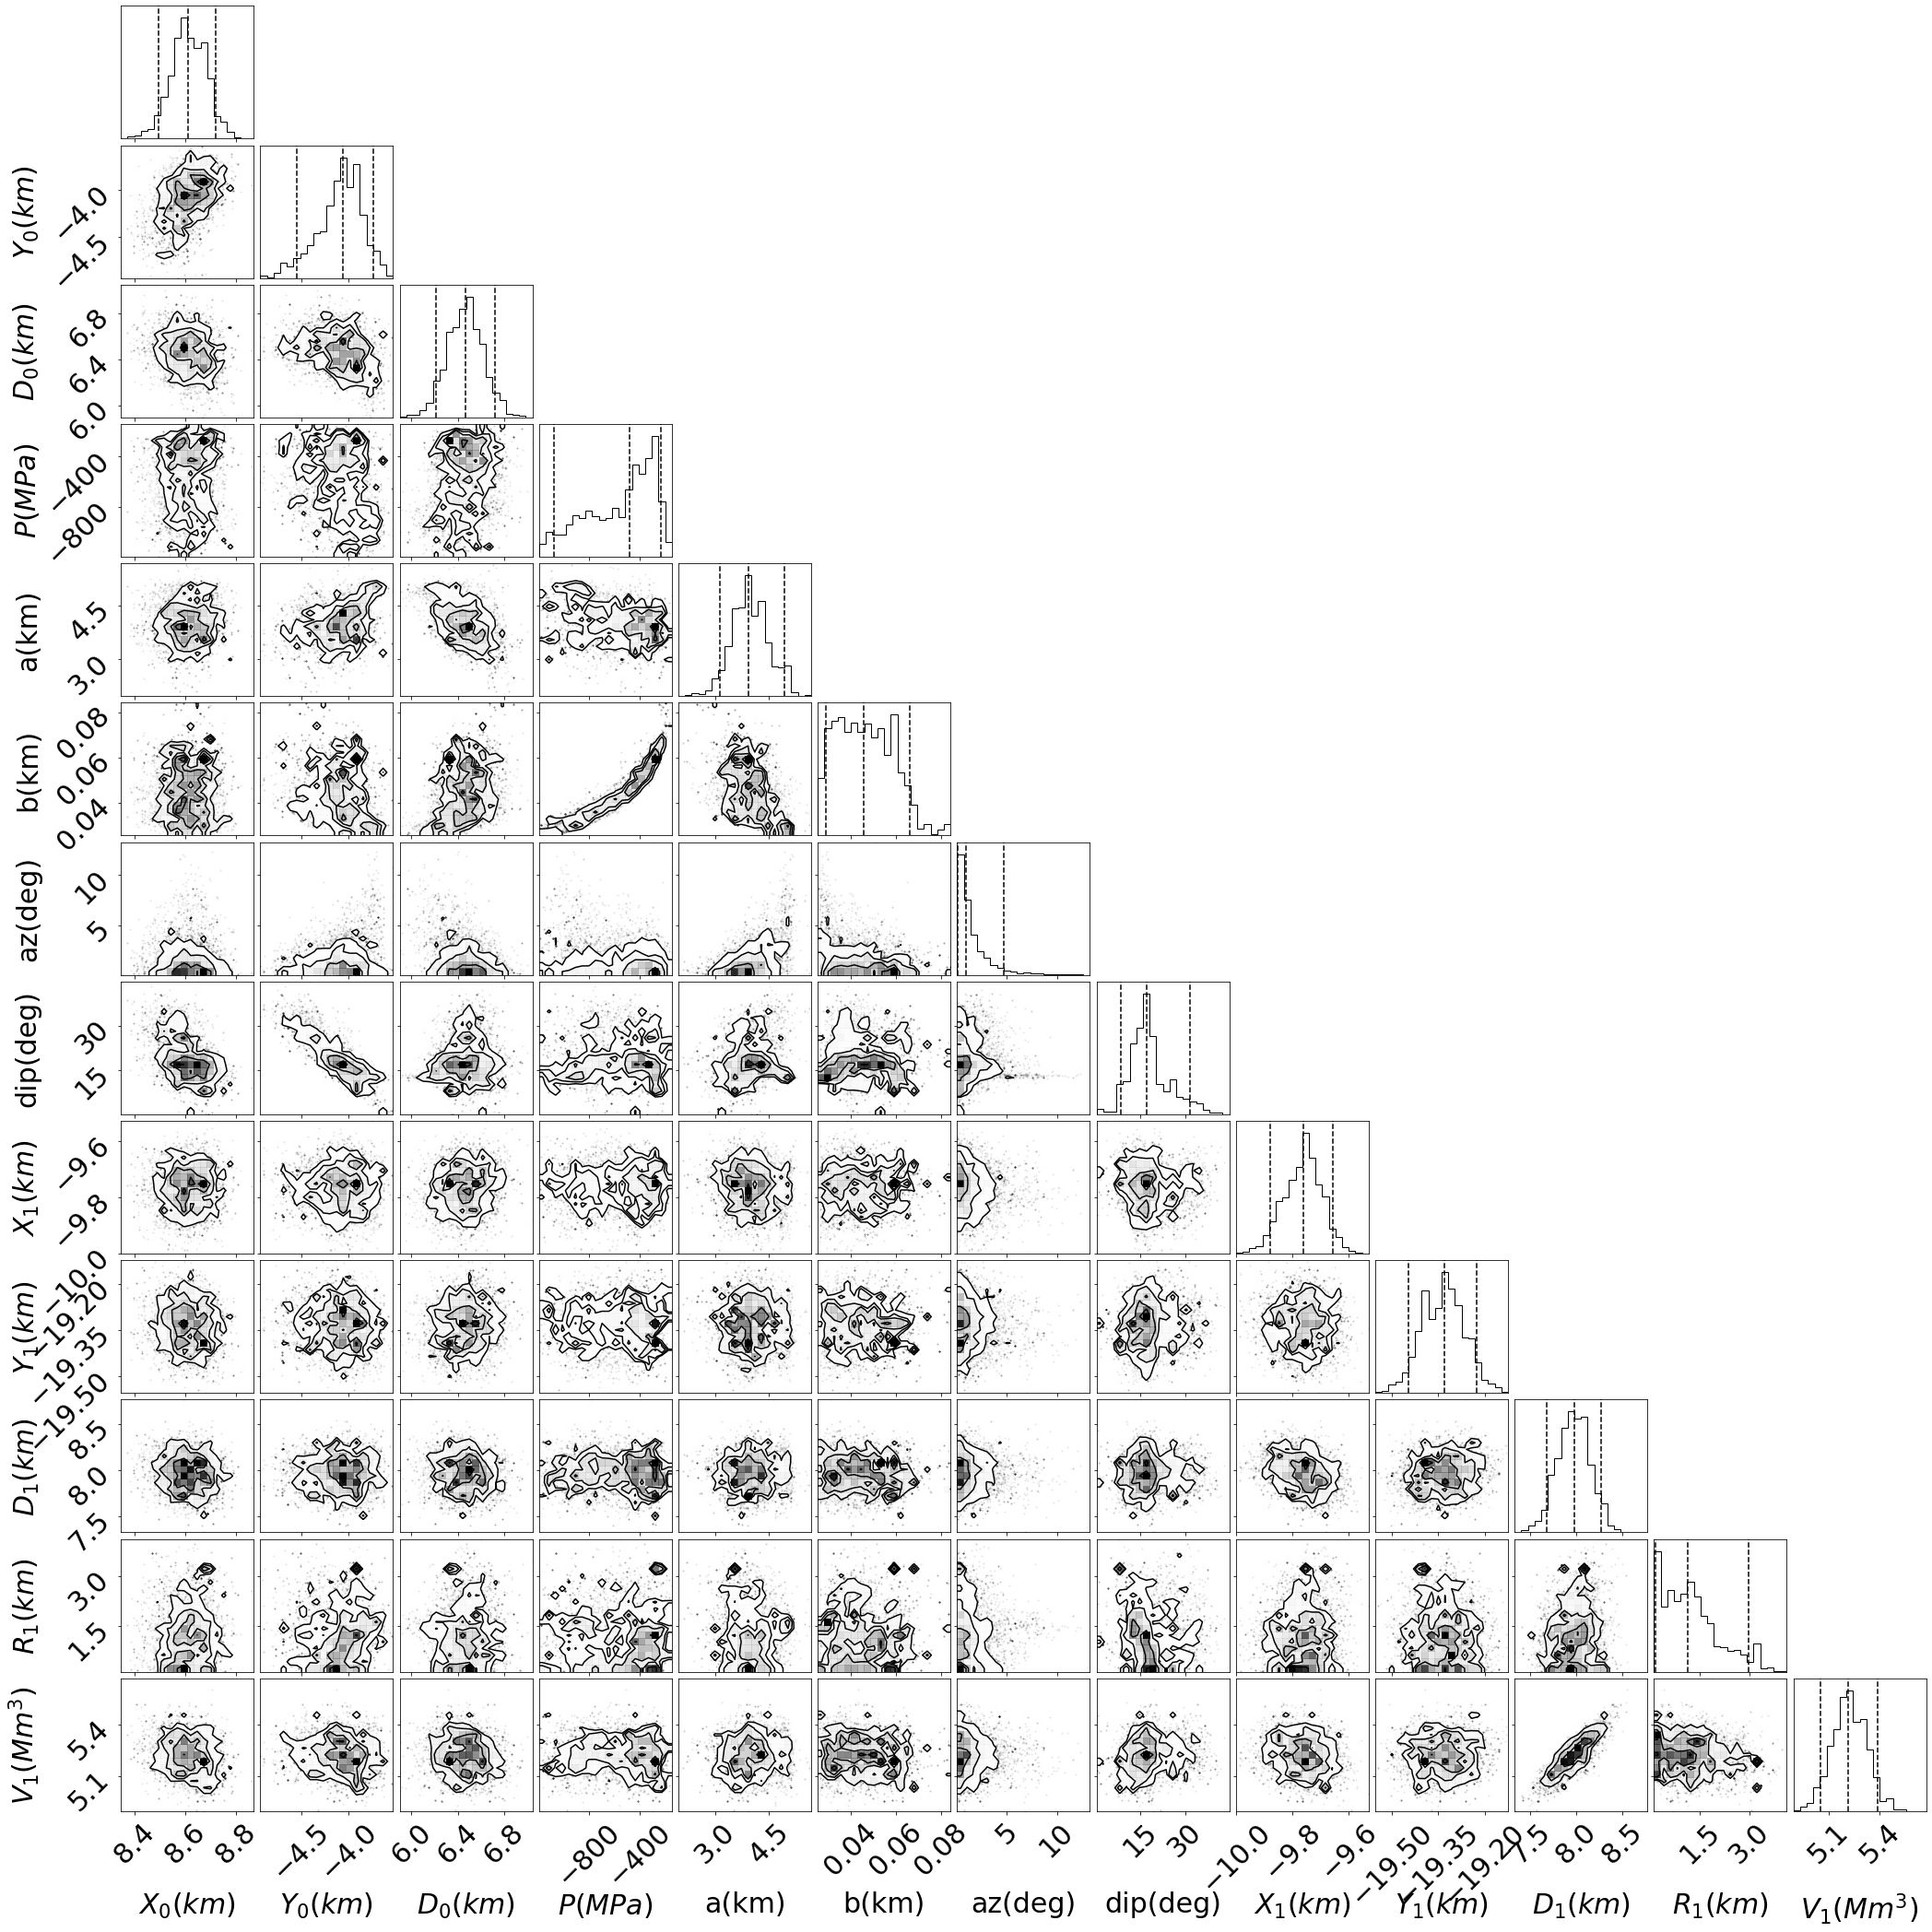

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)

newdata=np.copy(data)
newdata[3,:]=(4/3)*np.pi*data[3,:]*data[4,:]*data[5,:]**2/9.6e9
newdata[5,:]=newdata[5,:]/newdata[4,:]

newdata[0:3,:]=newdata[0:3]/1e3
newdata[3,:]=newdata[3,:]/1e6
newdata[4,:]=newdata[4,:]/1e3
newdata[8:11,:]=newdata[8:11,:]/1e3
newdata[11,:]=newdata[11,:]/1e3
newdata[12,:]=newdata[12,:]/1e6

data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e6
data[4,:]=data[4,:]/1e3
data[5,:]=data[5,:]/1e3
data[8:11,:]=data[8:11,:]/1e3
data[11,:]=data[11,:]/1e3
data[12,:]=data[12,:]/1e6

labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$',r'$D_{0}(km)$','$P (MPa)$','a(km)','b(km)','az(deg)','dip(deg)',r'$X_{1} (km)$',r'$Y_{1} (km)$',r'$D_{1}(km)$',r'$R_{1}(km)$',r'$V_{1}(Mm^{3})$']
#labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$',r'$D_{0}(km)$','$\Delta{V}_{0}(Mm^{3})$','a(km)','ratio','az(deg)','dip(deg)',r'$X_{1} (km)$',r'$Y_{1} (km)$',r'$D_{1}(km)$',r'$R_{1}(km)$',r'$\Delta{V}_{1}(Mm^{3})$']

ranges=[(8,11),(-5,-2),(4,10),(-1300,1),(2,12),(0,2.5),(0,50),(50,90),(-11,-9),(-20,-19),(7,10),(0,4),(3,6)]

lsans=[ans.x[0]/1e3,ans.x[1]/1e3,ans.x[2]/1e3,ans.x[3]/1e6,ans.x[4]/1e3,ans.x[5]/1e3,ans.x[6],ans.x[7],ans.x[8]/1e3,ans.x[9]/1e3,ans.x[10]/1e3,ans.x[11]/1e3,ans.x[12]/1e6]

plt.rcParams.update({'font.size': 30})

figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],max_n_ticks=3,labelpad=0.3,
                       show_titles=False, title_kwargs={"fontsize": 30})

#corner.overplot_points(figure, np.array(lsans)[None], color="C"+str(i),marker='s')
plt.savefig('histograms')

9.854816006313047 895


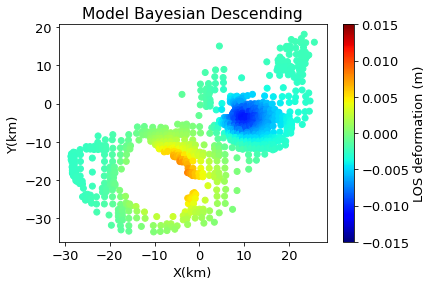

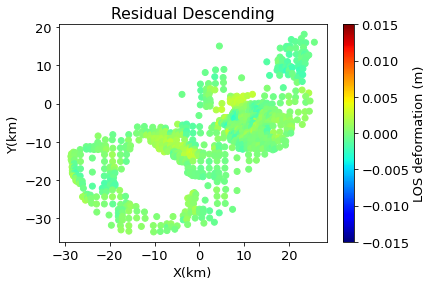

In [22]:
xbest=np.median(data,axis=1)
xbest[0:3]=xbest[0:3]*1e3
xbest[3]=(xbest[3])*1e6
xbest[4]=xbest[4]*1e3
xbest[5]=(xbest[5])*1e3
xbest[8:11]=xbest[8:11]*1e3
xbest[11]=xbest[11]*1e3
xbest[12]=xbest[12]*1e6

los_des=invin_des.forward(xbest)

plt.rcParams.update({'font.size': 13})

plt.figure()
plt.title('Model Bayesian Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Descending')
plt.scatter(obsin_des.xs/1e3,obsin_des.ys/1e3,c=obsin_des.get_data()-los_des,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_des.get_data()-los_des)*1e2)**2),len(los_des))

9.024955694636022 800


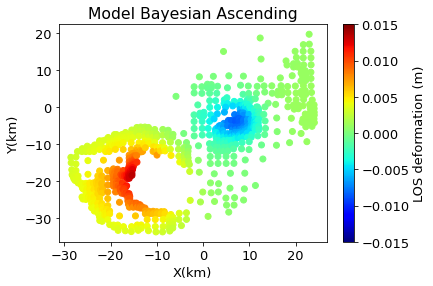

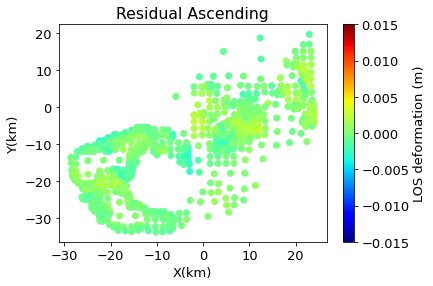

In [23]:
los_asc=invin_asc.forward(xbest)

plt.figure()
plt.title('Model Bayesian Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

plt.figure()
plt.title('Residual Ascending')
plt.scatter(obsin_asc.xs/1e3,obsin_asc.ys/1e3,c=obsin_asc.get_data()-los_asc,cmap='jet',vmin=-0.015,vmax=0.015)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')
plt.colorbar(label='LOS deformation (m)')

print(np.sum(((obsin_asc.get_data()-los_asc)*1e2)**2),len(los_asc))

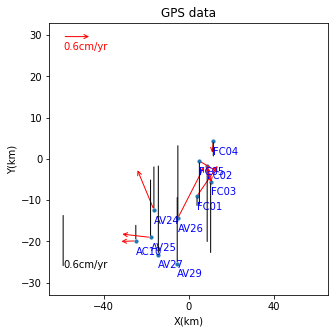

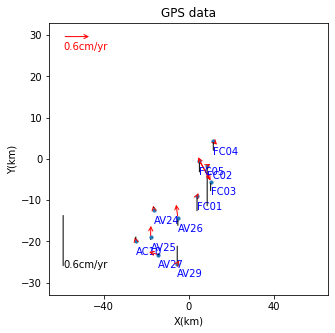

0.8068637568639156


In [24]:
%matplotlib inline
uxsm,uysm,uzsm=invg.forward(xbest,unravel=False)

uxs,uys,uzs=obsg.get_data(unravel=False)

util.plot_gnss(obsg.xs,obsg.ys,uxsm,uysm,uzsm,names=names,scl=0.6)
#plt.title('Model Bayesian GPS')

util.plot_gnss(obsg.xs,obsg.ys,uxs-uxsm,uys-uysm,uzs-uzsm,names=names,scl=0.6)
#plt.title('Residuals GPS')

print(np.sum((uxs*1e2-uxsm*1e2)**2+(uys*1e2-uysm*1e2)**2+(uzs*1e2-uzsm*1e2)**2))

## Save forward models from Bayesian inversion

Here we save the results from the Bayesian inversions and put them into matrices

In [25]:
util.los2npy(obsin_des.get_data(),'examples/insar/unimak_des_ref.csv',maskfile='./mask_unimak_des.npy',output='./unimak_insar_des.npy')
util.los2npy(los_des,'examples/insar/unimak_des_ref.csv',maskfile='./mask_unimak_des.npy',output='./unimak_joint_des_emc_NOAM.npy')
util.los2npy(obsin_des.get_data()-los_des,'examples/insar/unimak_des_ref.csv',maskfile='./mask_unimak_des.npy',output='./unimak_joint_des_emc_res_NOAM.npy')

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 (-164.95272888220853,
  -164.06647286421406,
  54.38869946788435,
  54.92045307868102))

In [26]:
util.los2npy(obsin_asc.get_data(),'examples/insar/unimak_asc_ref.csv',maskfile='./mask_unimak_asc.npy',output='./unimak_insar_asc.npy')
util.los2npy(los_asc,'examples/insar/unimak_asc_ref.csv',maskfile='./mask_unimak_asc.npy',output='./unimak_joint_asc_emc_NOAM.npy')
util.los2npy(obsin_asc.get_data()-los_asc,'examples/insar/unimak_asc_ref.csv',maskfile='./mask_unimak_asc.npy',output='./unimak_joint_asc_emc_res_NOAM.npy')

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 (-164.96499666450117,
  -164.12175031191683,
  54.38552515474153,
  54.92376750745494))

In [27]:
np.savetxt('unimak_gnss_emc_joint_NOAM.txt',np.c_[names,obsg.lons,obsg.lats,uxsm,uysm,uzsm],fmt='%s')

In [28]:
np.savetxt('unimak_gnss_emc_res_joint_NOAM.txt',np.c_[names,obsg.lons,obsg.lats,uxs-uxsm,uys-uysm,uzs-uzsm],fmt='%s')

In [29]:
xsf=np.array([np.percentile(data[0,:],p)*1e3+obsg.utmz[0] for p in [5,50,95]])
ysf=np.array([np.percentile(data[1,:],p)*1e3+obsg.utmz[1] for p in [5,50,95]])
xsw=np.array([np.percentile(data[8,:],p)*1e3+obsg.utmz[0] for p in [5,50,95]])
ysw=np.array([np.percentile(data[9,:],p)*1e3+obsg.utmz[1] for p in [5,50,95]])
print(obsg.utmz)
lonsf,latsf=util.utm2ll(xsf,ysf,int(obsg.utmz[2]),obsg.utmz[3])
print(lonsf[1],(lonsf[1]-lonsf[0]),(lonsf[2]-lonsf[1]))
print(latsf[1],(latsf[1]-latsf[0]),(latsf[2]-latsf[1]))
lonsw,latsw=util.utm2ll(xsw,ysw,int(obsg.utmz[2]),obsg.utmz[3])
print(lonsw[1],(lonsw[1]-lonsw[0]),(lonsw[2]-lonsw[1]))
print(latsw[1],(latsw[1]-latsw[0]),(latsw[2]-latsw[1]))

[532222.3275269632, 6061523.297986083, 3, 'U']
-164.3669529969781 0.0018426291555897478 0.0017463795499566004
54.66289306363128 0.004363457492253531 0.002903798691953341
-164.65293283295765 0.0018542281028430807 0.0016299163127655447
54.5268071579902 0.001029251501101669 0.0009420993289666058


In [22]:
for i in range(data.shape[0]):
    print(labels[i])
    print(np.percentile(newdata[i,:],5)-np.percentile(newdata[i,:],50))
    print(np.percentile(newdata[i,:],50))
    print(np.percentile(newdata[i,:],95)-np.percentile(newdata[i,:],50))

$X_{0} (km)$
-0.11449062834077317
8.611289446858228
0.1097252875477519
$Y_{0} (km)$
-0.4865938873530098
-4.05972921794274
0.3241240241220531
$D_{0}(km)$
-0.2587164592249307
6.468261518769641
0.2542045429405624
$P (MPa)$
-0.18800184226688388
-1.7288964606817898
0.10348372457418331
a(km)
-0.8133188622136709
3.9449728098361163
0.9923806893240839
b(km)
-0.005784545728621463
0.011803257733312826
0.007226570079525306
az(deg)
-0.8279728361630353
1.0031563650560855
3.713233176952839
dip(deg)
-8.538458768771378
17.11033396102935
14.673768050332907
$X_{1} (km)$
-0.11944138848030228
-9.760483472194366
0.10496658736376396
$Y_{1} (km)$
-0.11511481677518631
-19.330834735277044
0.10534862171178361
$D_{1}(km)$
-0.29481752351147605
7.97405602368989
0.2916505300895551
$R_{1}(km)$
-0.9661200190899997
1.1237980429014411
1.8414363669334113
$V_{1}(Mm^{3})$
-0.1646660480124824
5.217112406051752
0.1689256518216098
